In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [17]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=2)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                         shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.83MB/s]


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [18]:
class Identical(nn.Module):
    def forward(self, x):
        return x

In [19]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=128),  # Первый скрытый слой с 128 нейронами
    activation(),  # Активация ELU
    nn.Linear(in_features=128, out_features=128),  # Второй скрытый слой с 128 нейронами
    activation(),  # Активация ELU
    nn.Linear(in_features=128, out_features=10)   # Выходной слой с 10 нейронами
)

# Задаем функцию потерь (кросс-энтропия)
loss_function = nn.CrossEntropyLoss()

In [20]:
criterion = loss_function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)

            preds = outp.argmax(dim=-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)

            epoch_correct += correct.item()
            epoch_all += all

        accuracy_epoch = epoch_correct / epoch_all
        accuracy[k].append(accuracy_epoch)

        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {accuracy_epoch:.4f}")



Epoch: 1
Loader: train. Accuracy: 0.9031
Loader: valid. Accuracy: 0.9453
Epoch: 2
Loader: train. Accuracy: 0.9553
Loader: valid. Accuracy: 0.9590
Epoch: 3
Loader: train. Accuracy: 0.9661
Loader: valid. Accuracy: 0.9670
Epoch: 4
Loader: train. Accuracy: 0.9733
Loader: valid. Accuracy: 0.9640
Epoch: 5
Loader: train. Accuracy: 0.9770
Loader: valid. Accuracy: 0.9728
Epoch: 6
Loader: train. Accuracy: 0.9804
Loader: valid. Accuracy: 0.9709
Epoch: 7
Loader: train. Accuracy: 0.9814
Loader: valid. Accuracy: 0.9759
Epoch: 8
Loader: train. Accuracy: 0.9843
Loader: valid. Accuracy: 0.9807
Epoch: 9
Loader: train. Accuracy: 0.9855
Loader: valid. Accuracy: 0.9810
Epoch: 10
Loader: train. Accuracy: 0.9870
Loader: valid. Accuracy: 0.9782


### Протестируем разные функции активации.
Попробуем разные функции активации. Для каждой функции активации посчитаем массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [23]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    max_epochs = 10
    valid_accuracy = []

    for epoch in range(max_epochs):
        epoch_correct = 0
        epoch_all = 0
        model.train()

        for x_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            outp = model(x_batch)
            loss = criterion(outp, y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dataloader:
                outp = model(x_batch)
                preds = outp.argmax(dim=-1)
                correct = (preds == y_batch).sum().item()
                all_samples = y_batch.size(0)

                epoch_correct += correct
                epoch_all += all_samples

        accuracy = epoch_correct / epoch_all
        valid_accuracy.append(accuracy)

    return valid_accuracy

In [24]:
elu_accuracy = accuracy["valid"]
plain_accuracy = test_activation_function(nn.Identity)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

# Теперь у нас есть массивы с точностью для каждой активации
print(f"ELU Accuracy: {elu_accuracy}")
print(f"Identity Accuracy: {plain_accuracy}")
print(f"ReLU Accuracy: {relu_accuracy}")
print(f"Leaky ReLU Accuracy: {leaky_relu_accuracy}")

ELU Accuracy: [0.9453, 0.959, 0.967, 0.964, 0.9728, 0.9709, 0.9759, 0.9807, 0.981, 0.9782]
Identity Accuracy: [0.8989, 0.9034, 0.9088, 0.9146, 0.905, 0.9058, 0.9086, 0.9127, 0.913, 0.9001]
ReLU Accuracy: [0.9399, 0.9509, 0.9653, 0.9635, 0.9709, 0.9753, 0.9709, 0.9751, 0.971, 0.9688]
Leaky ReLU Accuracy: [0.9306, 0.9569, 0.9623, 0.9668, 0.9706, 0.9668, 0.9668, 0.9686, 0.9721, 0.9732]


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

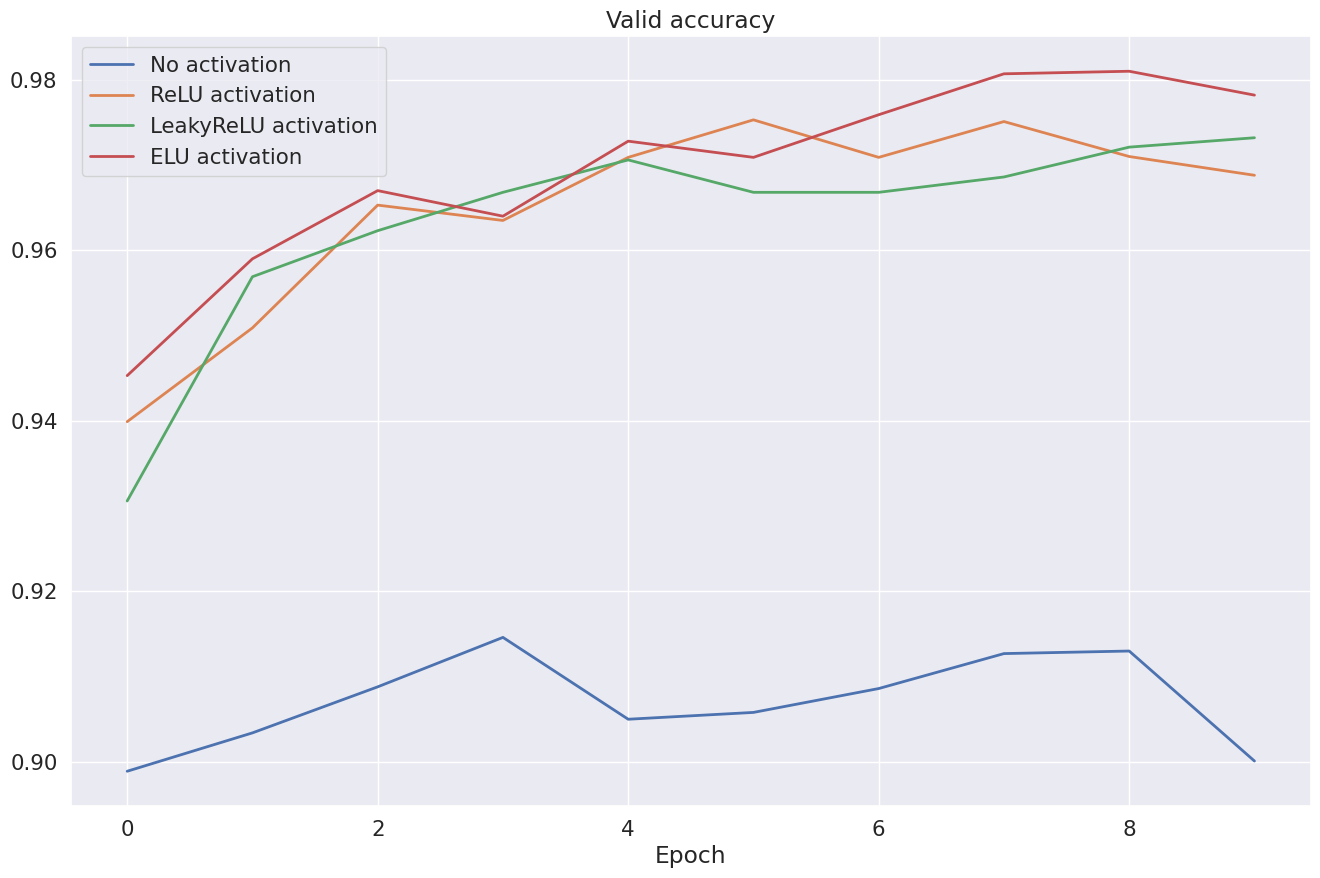

In [25]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

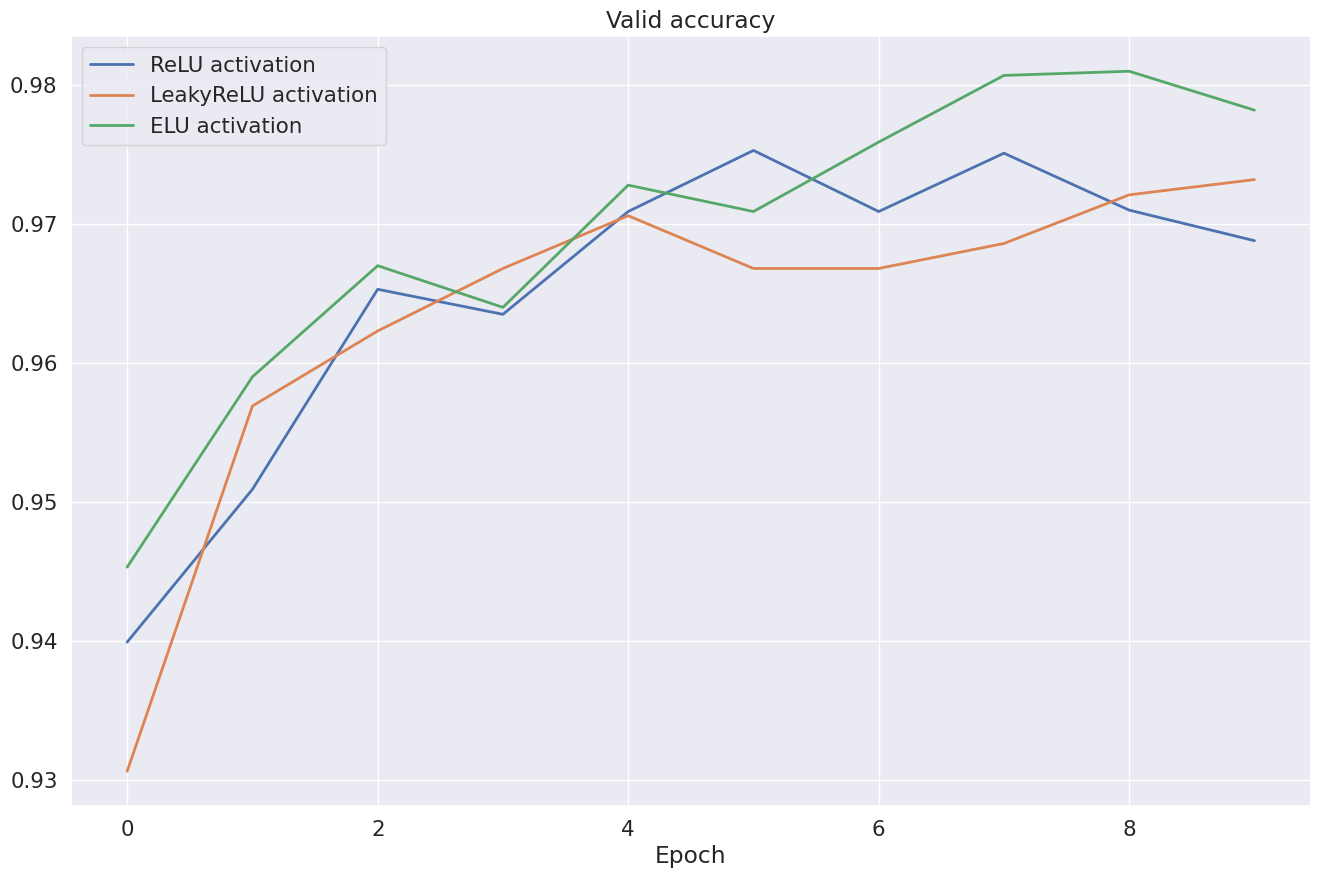

In [26]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

## Сверточные нейронные сети

### Реализуем LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используем модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [33]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        # 1 input image channel, 6 output channels, 3x3 square convolutional kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)  # first pooling layer with a 2x2 kernel
        self.conv2 = nn.Conv2d(6, 16, 3) # second conv layer, 16 output channels
        self.pool2 = nn.MaxPool2d(2, 2)  # second pooling layer with a 2x2 kernel

        # fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 feature maps size after two poolings
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # output layer (e.g., 10 classes for digit classification)

    def forward(self, x):
        # Pass through conv and pooling layers
        x = self.pool1(torch.relu(self.conv1(x)))  # conv1 + relu + pool1
        x = self.pool2(torch.relu(self.conv2(x)))  # conv2 + relu + pool2

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(-1, 16 * 5 * 5)  # flatten all dimensions except batch

        # Pass through fully connected layers
        x = torch.relu(self.fc1(x))  # fc1 + relu
        x = torch.relu(self.fc2(x))  # fc2 + relu
        x = self.fc3(x)  # output layer (logits, no activation)

        return x


In [34]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Обучим CNN


In [35]:
max_epochs = 10
accuracy = {"train": [], "valid": []}

for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)

            preds = outp.argmax(dim=-1)
            correct = (preds == y_batch).sum()
            all = y_batch.size(0)

            epoch_correct += correct.item()
            epoch_all += all

        accuracy_epoch = epoch_correct / epoch_all
        accuracy[k].append(accuracy_epoch)

        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {accuracy_epoch:.4f}")


Epoch: 1
Loader: train. Accuracy: 0.9169
Loader: valid. Accuracy: 0.9754
Epoch: 2
Loader: train. Accuracy: 0.9765
Loader: valid. Accuracy: 0.9802
Epoch: 3
Loader: train. Accuracy: 0.9829
Loader: valid. Accuracy: 0.9867
Epoch: 4
Loader: train. Accuracy: 0.9866
Loader: valid. Accuracy: 0.9877
Epoch: 5
Loader: train. Accuracy: 0.9889
Loader: valid. Accuracy: 0.9832
Epoch: 6
Loader: train. Accuracy: 0.9907
Loader: valid. Accuracy: 0.9875
Epoch: 7
Loader: train. Accuracy: 0.9919
Loader: valid. Accuracy: 0.9885
Epoch: 8
Loader: train. Accuracy: 0.9931
Loader: valid. Accuracy: 0.9892
Epoch: 9
Loader: train. Accuracy: 0.9941
Loader: valid. Accuracy: 0.9863
Epoch: 10
Loader: train. Accuracy: 0.9949
Loader: valid. Accuracy: 0.9894


In [36]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

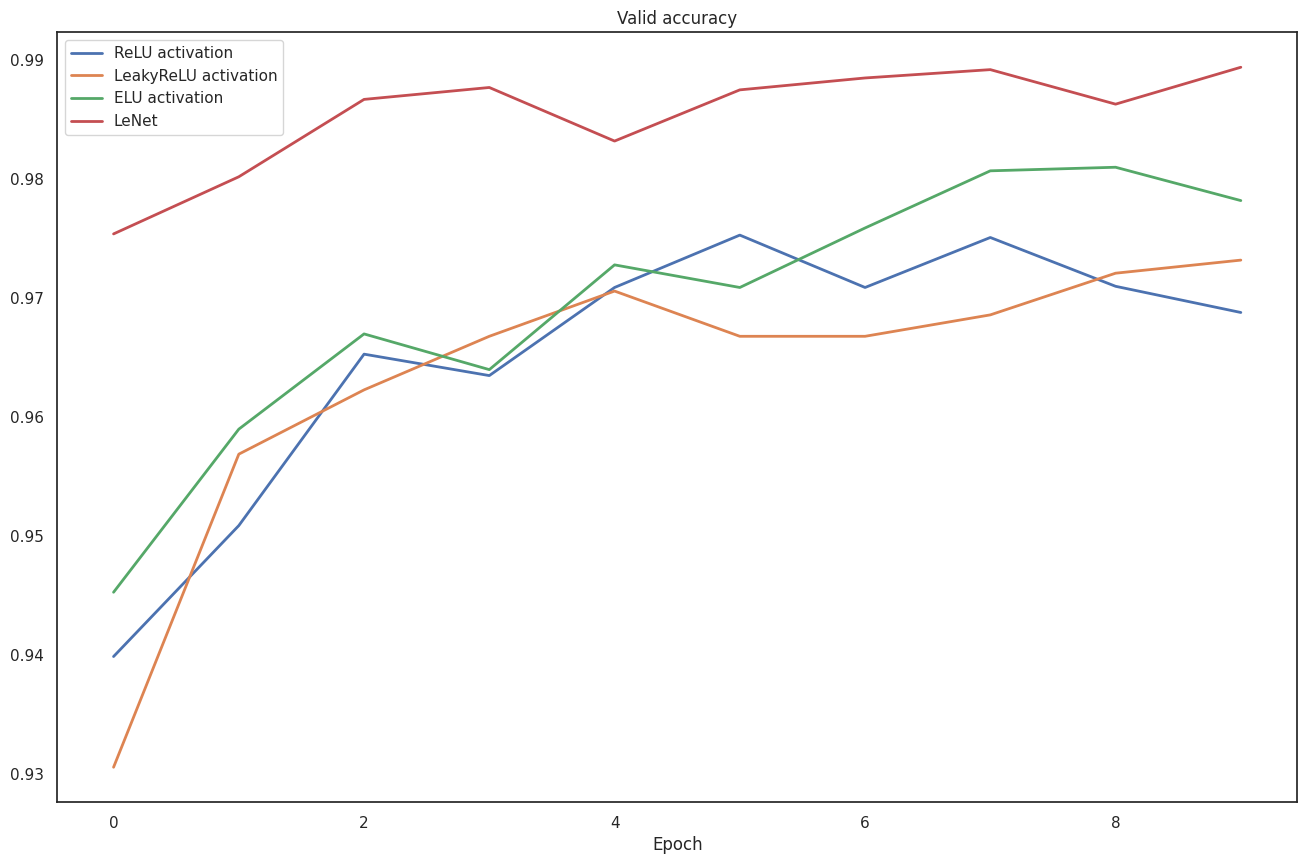

In [37]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

Посмотрим что получилось

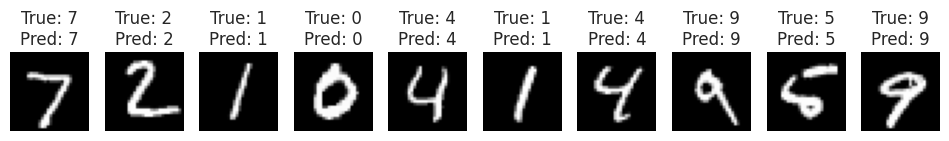

In [42]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(iter(loaders["valid"]))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

model.eval()
with torch.no_grad():
    outp = model(x_batch)
    preds = outp.argmax(dim=-1)

fig, axes = plt.subplots(1, 10, figsize=(12, 6))
for i in range(10):
    axes[i].imshow(x_batch[i].cpu().squeeze(), cmap="gray")
    axes[i].set_title(f"True: {y_batch[i].item()}\nPred: {preds[i].item()}")
    axes[i].axis("off")

plt.show()
